# LSTM Chem

This Python notebook creates an AI deep learning autoencoder model for learning how to reproduce SMILES molecules one character at a time. Since the molecule data is a sequence of characters, the autoencoder model is developed using Long Short Term Memory (LSTM) cells.

In [ ]:
# import core libraries 
import sys
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.2.0


In [ ]:
# load Keras libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import Sequence

In [ ]:
# enable GPU processing
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Sun May 31 14:56:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    34W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                

In [ ]:
# set random seed
seed = 777
np.random.seed(seed)
rn.seed(seed)

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [ ]:
# create data load functions
def load_data(data):
    with open(data, 'r') as f:
        smiles = [r.rstrip() for r in f]
    return np.array(smiles)

def load_dictionaries(input_dict):
    with open(input_dict, 'r') as fp:
        new_dict = json.load(fp)
    return new_dict  

In [ ]:
# load dataset & break into train/test sets
smifile = '/drive/My Drive/chem_data/smiles_cleaned.smi'
data = load_data(smifile)
full_train, test = train_test_split(data, test_size=0.2, random_state=seed)
print("Training smiles shape:", full_train.shape)
print("Test smiles shape:", test.shape)
print("Sample training smile: \n", full_train[2])

Training smiles shape: (351278,)
Test smiles shape: (87820,)
Sample training smile: 
 Cc1cc(Oc2ccc(-c3nc4cc(C(N)=O)ccc4[nH]3)cc2)ccc1F


In [ ]:
# save test file for smile generation
np.save('/drive/My Drive/chem_data/test.npy', test)
print('Test file saved to disk')

Test file saved to disk


In [ ]:
# create our validation dataset
val_split = 0.10
train, val_set = train_test_split(full_train, test_size=val_split, random_state=seed)
print("Training dataset shape:", train.shape)
print("Validation dataset shape:", val_set.shape)

Training dataset shape: (316150,)
Validation dataset shape: (35128,)


In [ ]:
# load the Python dictionaries that map characters-to-integers and intergers-to-characters
d1 = '/drive/My Drive/chem_data/char_to_int.json'
d2 = '/drive/My Drive/chem_data/int_to_char.json'
char_to_int = load_dictionaries(d1)
int_to_char = load_dictionaries(d2)
n_vocab = len(char_to_int)
print("Character set vocabulary length:", n_vocab)
print("Dictionary mapping characters-to-integers:\n", char_to_int)
print("Dictionary mapping integers-to-characters:\n", int_to_char)

Character set vocabulary length: 45
Dictionary mapping characters-to-integers:
 {'n': 0, '[': 1, '\\': 2, 'E': 3, 'H': 4, ')': 5, 'B': 6, '9': 7, '2': 8, ']': 9, '7': 10, '!': 11, 't': 12, 's': 13, 'o': 14, 'c': 15, 'K': 16, '-': 17, '/': 18, 'l': 19, 'A': 20, 'r': 21, '@': 22, 'C': 23, '=': 24, '6': 25, 'N': 26, 'L': 27, 'a': 28, '5': 29, 'S': 30, 'T': 31, '#': 32, '+': 33, 'P': 34, 'i': 35, '(': 36, '8': 37, '1': 38, 'I': 39, 'e': 40, 'O': 41, '3': 42, 'F': 43, '4': 44}
Dictionary mapping integers-to-characters:
 {'0': 'n', '1': '[', '2': '\\', '3': 'E', '4': 'H', '5': ')', '6': 'B', '7': '9', '8': '2', '9': ']', '10': '7', '11': '!', '12': 't', '13': 's', '14': 'o', '15': 'c', '16': 'K', '17': '-', '18': '/', '19': 'l', '20': 'A', '21': 'r', '22': '@', '23': 'C', '24': '=', '25': '6', '26': 'N', '27': 'L', '28': 'a', '29': '5', '30': 'S', '31': 'T', '32': '#', '33': '+', '34': 'P', '35': 'i', '36': '(', '37': '8', '38': '1', '39': 'I', '40': 'e', '41': 'O', '42': '3', '43': 'F', '44

In [ ]:
# create a function to turn the dataset into a supervised problem, add the beginning and ending character markers, 
# add padding for constant sequence length, and turn the sequence into a sequence of one-hot vectors
def vectorize(smiles, embed, n_vocab):
    one_hot = np.zeros((smiles.shape[0], embed, n_vocab), dtype=np.int8)
    for i, smile in enumerate(smiles):
        # encode the start
        one_hot[i,0,char_to_int["!"]] = 1
        #encode the smiles characters
        for j, c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        # encode the end of the smiles string
        one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
    # return two items, one for input and one for output
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [ ]:
# create our X & y datasets
embed = 101
X_train, y_train = vectorize(train, embed, n_vocab)
X_val, y_val = vectorize(val_set, embed, n_vocab)
X_test, y_test = vectorize(test, embed, n_vocab)
print("Training input shape:", X_train.shape)
print("Training output shape:", y_train.shape)
print("Validation input shape:", X_val.shape)
print("Validation output shape:", y_val.shape)
print("Test input shape:", X_test.shape)
print("Test output shape:", y_test.shape)

Training input shape: (316150, 100, 45)
Training output shape: (316150, 100, 45)
Validation input shape: (35128, 100, 45)
Validation output shape: (35128, 100, 45)
Test input shape: (87820, 100, 45)
Test output shape: (87820, 100, 45)


The int_to_char dictionary can be used to go from the vectorized form back to a readable SMILES string, with a joined list comprehension.

In [ ]:
"".join([int_to_char[str(idx)] for idx in np.argmax(X_train[0,:,:], axis=1)])

'!O=c1ccc(OCCCN2CCN(c3csc4ccccc34)CC2)nn1-c1ccc(Cl)c(Cl)c1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE'

In [ ]:
# define the LSTM Chem model
def lstm_model(X, y):
    # define the encoder layers
    enc_input = Input(shape=(X.shape[1:]))
    _, state_h, state_c = LSTM(256, return_state=True)(enc_input)
    states = Concatenate(axis=-1)([state_h, state_c])
    bottle_neck = Dense(128, activation='relu')(states)

    # define the decoder layers
    state_h_decoded = Dense(256, activation='relu')(bottle_neck)
    state_c_decoded = Dense(256, activation='relu')(bottle_neck)
    encoder_states = [state_h_decoded, state_c_decoded]
    dec_input = Input(shape=(X.shape[1:]))
    dec1 = LSTM(256, return_sequences=True)(dec_input, initial_state=encoder_states)
    output = Dense(y.shape[2], activation='softmax')(dec1)
    
    model = Model(inputs=[enc_input, dec_input], outputs=output)   
    return model 

In [ ]:
# instantiate our neural network model
model = lstm_model(X_train, y_train)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 45)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 309248      input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512)          0           lstm[0][1]                       
                                                                 lstm[0][2]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          65664       concatenate[0][0]            

In [ ]:
# compile the model
batch_size = 256
steps_per_epoch = len(X_train) // batch_size
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=steps_per_epoch*50, decay_rate=1.0, staircase=False)
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
# define our data sequence generator class
class Data_Generator(Sequence):
    def __init__(self, input_data, labels, batch_size):
        self.input_data, self.labels = input_data, labels
        self.batch_size = batch_size
    
    def __len__(self):
        return int(np.ceil(len(self.input_data) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        x = self.input_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_x, batch_y = np.array(x), np.array(y)
        
        return [batch_x, batch_x], batch_y

In [ ]:
# create object instances of our sequence generator
training_generator = Data_Generator(X_train, y_train, batch_size)
validation_generator = Data_Generator(X_val, y_val, batch_size)

In [ ]:
# create our callbacks
file="/drive/My Drive/chem_data/LSTM_Chem_weights-{epoch:02d}-{acc:.4f}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
tb = TensorBoard(log_dir="/drive/My Drive/logs/chem/", histogram_freq=1, write_graph=True, write_images=True)

In [ ]:
# fit the model
nb_epochs = 225
validation_steps = len(X_val) // batch_size
history = model.fit(training_generator, steps_per_epoch=steps_per_epoch, epochs=nb_epochs, verbose=1, 
                              validation_data=validation_generator, validation_steps=validation_steps, 
                             use_multiprocessing=False, shuffle=True, callbacks=[])

Epoch 1/225
1234/1234 [==============================] - 51s 41ms/step - loss: 0.8086 - acc: 0.7491 - val_loss: 0.5616 - val_acc: 0.8133
Epoch 2/225
1234/1234 [==============================] - 50s 41ms/step - loss: 0.5077 - acc: 0.8286 - val_loss: 0.4670 - val_acc: 0.8394
Epoch 3/225
1234/1234 [==============================] - 51s 41ms/step - loss: 0.4451 - acc: 0.8462 - val_loss: 0.4221 - val_acc: 0.8531
Epoch 4/225
1234/1234 [==============================] - 51s 41ms/step - loss: 0.4102 - acc: 0.8567 - val_loss: 0.3968 - val_acc: 0.8609
Epoch 5/225
1234/1234 [==============================] - 50s 40ms/step - loss: 0.3877 - acc: 0.8637 - val_loss: 0.3780 - val_acc: 0.8668
Epoch 6/225
1234/1234 [==============================] - 50s 41ms/step - loss: 0.3715 - acc: 0.8690 - val_loss: 0.3616 - val_acc: 0.8721
Epoch 7/225
1234/1234 [==============================] - 50s 41ms/step - loss: 0.3459 - acc: 0.8783 - val_loss: 0.3346 - val_acc: 0.8822
Epoch 8/225
1234/1234 [==================

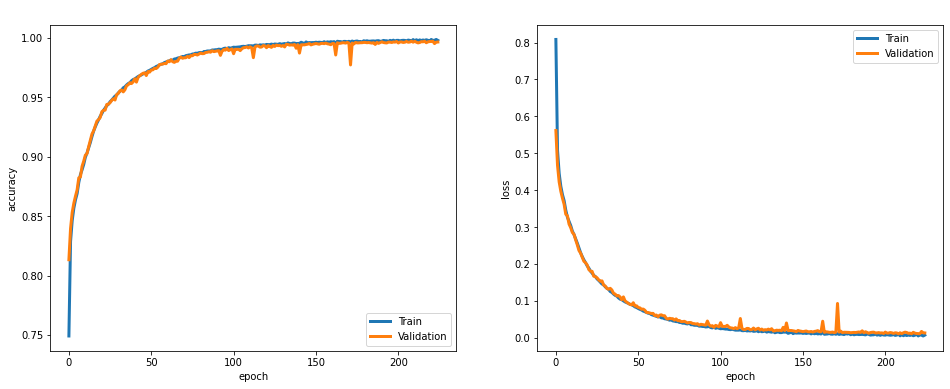

In [ ]:

# plot the model loss and accuracy
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history["acc"], label='Train', linewidth=3)
axis1.plot(history.history["val_acc"], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16, color="white")
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='lower right')

# summarize history for loss
axis2.plot(history.history["loss"], label='Train', linewidth=3)
axis2.plot(history.history["val_loss"], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16, color="white")
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [ ]:
# evaluate our test set
score, acc = model.evaluate([X_test, X_test], y_test, batch_size=batch_size, verbose=0)
print(f'Test score: {score}')
print(f'Test accuracy: {acc}')

Test score: 0.01221152488142252
Test accuracy: 0.9965562224388123


In [ ]:
# save our baseline training model & weights
mod_file = '/drive/My Drive/chem_data/LSTM_model.h5'
model.save(mod_file)
print("Model Saved")

Model Saved
